In [1]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras import optimizers
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy, mae
from keras.utils import plot_model
from keras import backend as K

import numpy as np
from skimage import exposure
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from ipywidgets import interact, interact_manual, FloatSlider, IntSlider, HBox
import seaborn as sns
import argparse
import os

C:\Users\fredrik.fagerholm\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
img_size = 32
num_symbols = 62

In [3]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [4]:
def reshape_font_data(font_vector):
    symbol_matrix = font_vector.reshape((num_symbols, img_size, img_size))
    
    image = np.zeros(shape=(img_size*8, img_size*8))

    for i in range(8):
        for j in range(8):
            if i*8 + j < 62:
                image[i*img_size:(i+1)*img_size, j*img_size:(j+1)*img_size] = symbol_matrix[i*8 + j, :, :]

    return image
    

def reshape_and_plot_image(font_vector, title='', figsize=(12, 12), fontsize=16):
    image = reshape_font_data(font_vector)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image, cmap=plt.cm.gray_r)
    ax.set_title(title, fontsize=fontsize)
    
    return ax

In [5]:
print("Loading fonts data.")
font_data = np.load('../data/processed/font_vectors_small.npz')
X = font_data['data']
print("Done.")
n_samples, original_dim = X.shape

y = np.arange(n_samples)

x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True, 
                                                    random_state=0)

Loading fonts data.
Done.


In [30]:
X[0, :].shape

(63488,)

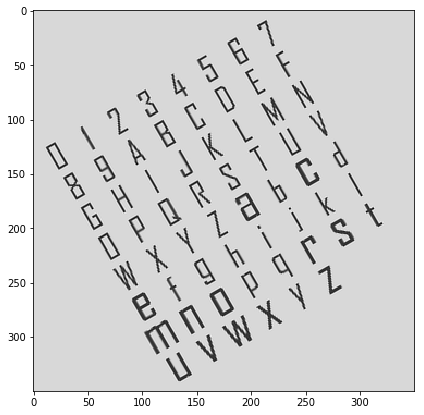

In [33]:

plt.figure(figsize=(7,7))
plt.imshow(scipy.ndimage.rotate(reshape_font_data(X[0, :]), 30), cmap=plt.cm.gray_r)
plt.show()

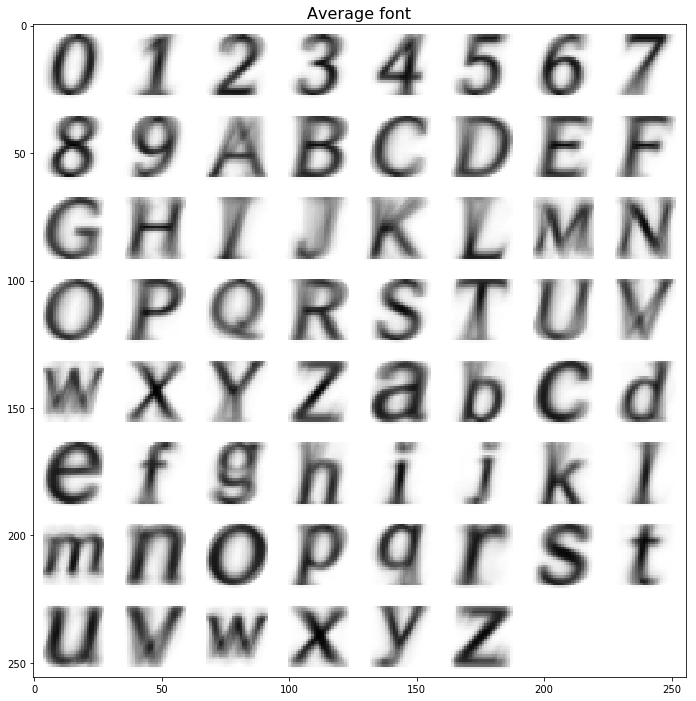

In [6]:
avg_font = np.mean(X, axis=0)
ax = reshape_and_plot_image(avg_font, title='Average font', fontsize=16)
pass

In [7]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 128
batch_size = 128
latent_dim = 8
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 63488)        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          8126592     encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 8)            1032        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 8)            1032        dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [8]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1152      
_________________________________________________________________
dense_3 (Dense)              (None, 63488)             8189952   
Total params: 8,191,104
Trainable params: 8,191,104
Non-trainable params: 0
_________________________________________________________________


In [9]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_fonts')

In [10]:
models = (encoder, decoder)
data = (x_test, y_test)

# VAE loss = mse_loss + beta * kl_loss
reconstruction_loss = binary_crossentropy(inputs, outputs)

# beta is a hyperparameter that balances latent channel capacity and 
# independence constraints with reconstruction accuracy.
# higher beta forces the components of the latent variable to be less entagled, 
# but at the cost of lowering the reconstruction quality
beta = 1.0
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + beta*kl_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 63488)             0         
_________________________________________________________________
encoder (Model)              [(None, 8), (None, 8), (N 8128656   
_________________________________________________________________
decoder (Model)              (None, 63488)             8191104   
Total params: 16,319,760
Trainable params: 16,319,760
Non-trainable params: 0
_________________________________________________________________


In [11]:
MODEL_WEIGHTS_PATH = 'vae_B.h5'

if MODEL_WEIGHTS_PATH:
        vae.load_weights(MODEL_WEIGHTS_PATH)
else:
    # train the autoencoder
    vae.fit(X, 
            epochs=30,
            batch_size=batch_size,
            validation_split=0.2)
    vae.save_weights('vae_B.h5')

In [21]:
with open('../models/vae_decoder.json', 'w') as outfile:
    outfile.write(decoder.to_json())
    
decoder.save_weights('..models/vae_decoder_weights.h5')

In [23]:
decoder.save('../models/vae_decoder.h5')

C:\Users\fredrik.fagerholm\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


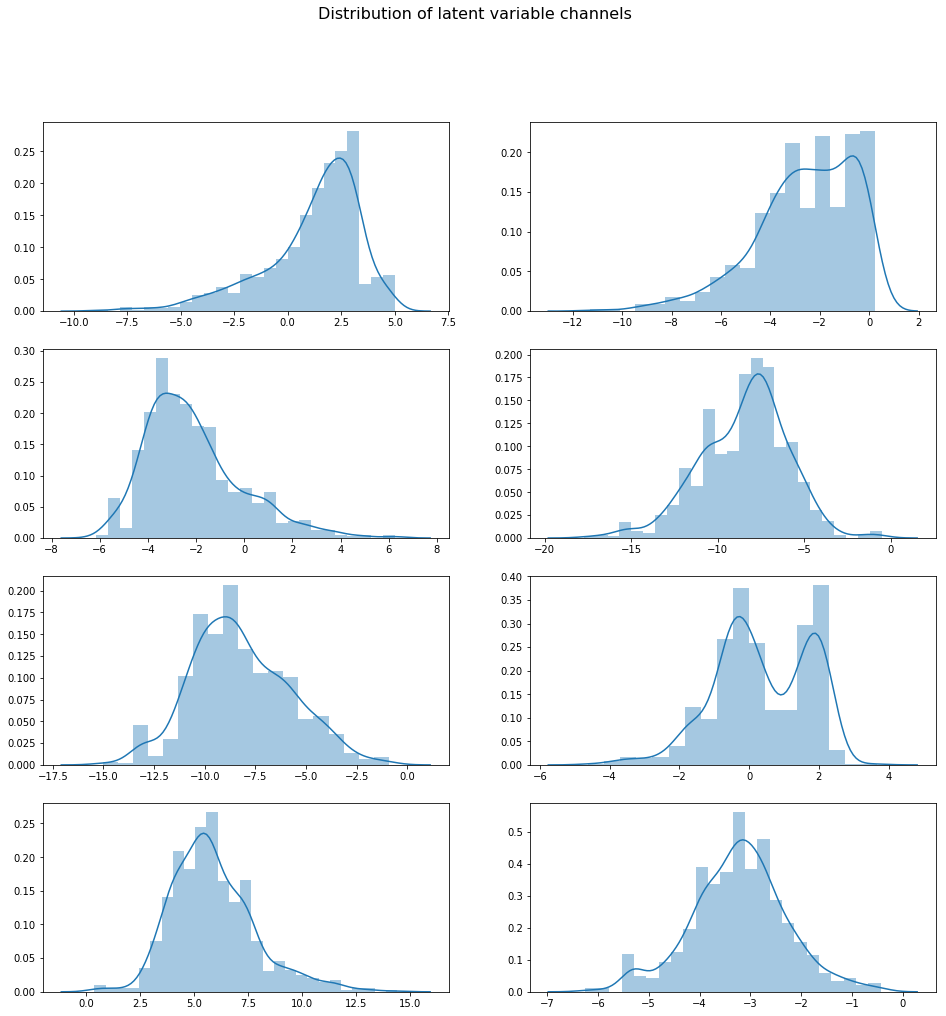

In [13]:
z_learnt = encoder.predict(x_train)[0]

%matplotlib inline
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))

for i, ax in enumerate(axes.ravel()):
    sns.distplot(z_learnt[:, i], ax=ax)
    
fig.suptitle('Distribution of latent variable channels', fontsize=16)
pass

In [20]:
from ipywidgets import Layout, Box

plt.rcParams['figure.figsize'] = 9, 9

def reconstruct_font(font_nr):
    x_decoded = vae.predict(X[[font_nr,], :])
    image = reshape_font_data(x_decoded[0])
    
    plt.imshow(image, cmap=plt.cm.gray_r)
    plt.title('Reconstruction of font number %d' % font_nr, fontsize=16)
    plt.show()

interact_manual(reconstruct_font, font_nr=IntSlider(min=0, max=n_samples - 1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='font_nr', max=1015), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function __main__.reconstruct_font>

In [32]:
from sklearn.manifold import TSNE

tsne_embedding = TSNE(n_components=2).fit_transform(z_learnt)

In [43]:
tsne_embedding[612]

array([-1.1123408, -7.4412246], dtype=float32)

In [38]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go

xs, ys = tsne_embedding.T 

init_notebook_mode(connected=True)

# Create a trace
trace = go.Scatter(
    x=xs,
    y=ys,
    mode='markers',
    marker=dict(size=5),
    text=y,
    hoverinfo = 'text',
)

layout = go.Layout(
    title= 't-SNE embedding font embeddings',
    hovermode= 'closest',
    xaxis=dict(
        title= 'x-axis',
        gridwidth= 2,
    ),
    yaxis=dict(
        title='y-axis',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig = go.Figure(data=[trace], layout=layout)

iplot(fig, filename='font-embeddings')

In [15]:
z_sample = np.random.normal(scale=8, size=(1, latent_dim))
z_sample[0, 0] = 15.0
z_sample[0, 1] = 20.0

x_decoded = decoder.predict(z_sample)

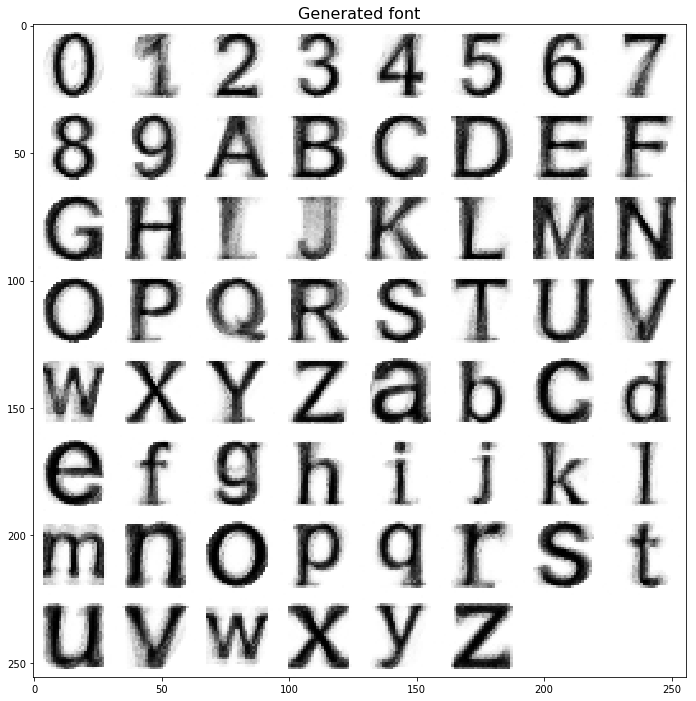

In [16]:
ax = reshape_and_plot_image(x_decoded[0], title='Generated font', fontsize=16)
plt.savefig('../figures/generated_font_3.png', bbox_inches='tight')

In [24]:
plt.rcParams['figure.figsize'] = 12, 12

def generate_font(z0, z1, z2, z3, z4, z5, z6, z7):
    z_sample = np.array([[z0, z1, z2, z3, z4, z5, z6, z7]])
    
    x_decoded = decoder.predict(z_sample)
    image = reshape_font_data(x_decoded[0])
    
    plt.imshow(image, cmap=plt.cm.gray_r)
    plt.title('Generated font', fontsize=16)
    plt.show()

lower, upper = -30, 30
im = interact_manual(generate_font, 
                     z0=FloatSlider(min=lower, max=upper, step=0.1),
                     z1=FloatSlider(min=lower, max=upper, step=0.1),
                     z2=FloatSlider(min=lower, max=upper, step=0.1),
                     z3=FloatSlider(min=lower, max=upper, step=0.1),
                     z4=FloatSlider(min=lower, max=upper, step=0.1),
                     z5=FloatSlider(min=lower, max=upper, step=0.1),
                     z6=FloatSlider(min=lower, max=upper, step=0.1),
                     z7=FloatSlider(min=lower, max=upper, step=0.1))

im.widget.children[-2].description = 'Generate font'

interactive(children=(FloatSlider(value=0.0, description='z0', max=30.0, min=-30.0), FloatSlider(value=0.0, description='z1', max=30.0, min=-30.0), FloatSlider(value=0.0, description='z2', max=30.0, min=-30.0), FloatSlider(value=0.0, description='z3', max=30.0, min=-30.0), FloatSlider(value=0.0, description='z4', max=30.0, min=-30.0), FloatSlider(value=0.0, description='z5', max=30.0, min=-30.0), FloatSlider(value=0.0, description='z6', max=30.0, min=-30.0), FloatSlider(value=0.0, description='z7', max=30.0, min=-30.0), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))